# Using a Transformer architecture to classify RGB spectrograms

This takes a slightly different approach, training on fixed input images to a single label. Thus, we want to choose an image size that is large enough to capture the relevant information, but small enough to be computationally feasible and also not introduce too much extra data to the classifier.

In [1]:
"""
SOURCE CREDIT: BASED ON THE ARCHITECTURE IN THE KERAS EXAMPLES:
Title: Timeseries classification with a Transformer model
Author: [Theodoros Ntakouris](https://github.com/ntakouris)
Date created: 2021/06/25
Last modified: 2021/08/05
Description: This notebook demonstrates how to do timeseries classification using a Transformer model.
Accelerator: GPU
"""
import keras
from keras import layers

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Attention and Normalization
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(res)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    return x + res

def build_model(
    input_shape: tuple,
    head_size: int,
    num_heads: int,
    ff_dim: int,
    num_transformer_blocks: int,
    mlp_units: int,
    n_classes: int,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_last")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(n_classes, activation="softmax")(x)
    return keras.Model(inputs, outputs)



2024-12-17 13:49:17.780565: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-17 13:49:17.786983: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734464957.794315  376119 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734464957.796454  376119 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-17 13:49:17.804845: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [26]:
import numpy as np

def rolling_window(x: np.ndarray, window_size: int, step_size: int=1) -> np.ndarray:
    """
    Create a rolling window view of the input array.
    """
    return np.lib.stride_tricks.sliding_window_view(x, window_shape=window_size, axis=0)[::step_size]

In [27]:
import os

print(os.getcwd())

/home/eric/Engineering/Work/pisces/examples/RGB_Spectrograms


In [28]:
import numpy as np


def prepare_stacked_spectrograms_experiment(data_dict, minutes_per_input, label_window_fraction: float = 0.5) -> dict:
    """data_dict is expected to have keys containing:
    dict_keys(['spectrogram', 'spec_times', 'spec_freqs', 'psg'])
    
    For the output of the standard preprocessing pipeline, we have pickled dicts with keys matching subject IDs, each value is a dict of the format for this function.
    """

    # spec_times is an array of the midpoint of each spectrogram vertical  pixel line 
    # (frequencies for a specific FFT time window)
    spec_times = data_dict['spec_times']
    # Convert these to minutes, to decide on the width of the input windows
    spec_times_minutes = spec_times / 60

    spec_data = data_dict['spectrogram']
    psg_data = data_dict['psg']
    PSG_STEP_SECONDS = 30
    ROLLING_WINDOW_STEP = int(np.sum(
        (spec_times<= 2 * PSG_STEP_SECONDS) 
        & (spec_times> PSG_STEP_SECONDS)
    )) # one PSG step, in spectrogram time idx
    WINDOW_LEN_IDX = minutes_per_input * 60 / (spec_times[1] - spec_times[0])

    psg_times_minutes = np.arange(0, len(psg_data) * PSG_STEP_SECONDS / 60, PSG_STEP_SECONDS / 60)

    wrapped_spec = rolling_window(spec_data, int(WINDOW_LEN_IDX), step_size=ROLLING_WINDOW_STEP)

    # this now has shape (n_windows, freqs, channels, time)
    # but we want (n_windows, time, freqs, channels) for training
    wrapped_spec = np.moveaxis(wrapped_spec, 3, 1)

    # Now we need to match each window to the PSG data
    psg_pre_trim_idx = minutes_per_input * 60 / PSG_STEP_SECONDS * label_window_fraction
    psg_post_trim_idx = minutes_per_input * 60 / PSG_STEP_SECONDS * (1-label_window_fraction)

    pruned_psg = psg_data[int(psg_pre_trim_idx):int(-psg_post_trim_idx)]

    return {
        'X': wrapped_spec,
        'y': pruned_psg
    }

In [29]:
from pathlib import Path
from examples.RGB_Spectrograms.preprocessing import prepare_data
from examples.RGB_Spectrograms.utils import load_preprocessed_data

preprocessed_path = Path("./pre_processed_data")
n_classes = 2
FREQ_DOWN = 4

static_preprocessed_data = load_preprocessed_data("stationary", preprocessed_path)
static_keys = list(static_preprocessed_data.keys())
static_data_bundle = prepare_data(static_preprocessed_data, 
                                    n_classes=n_classes,
                                    freq_downsample=FREQ_DOWN)


class weights:  {
  "-1": 0.0,
  "0": 5.887646161667514,
  "1": 0.5464024534088228
}


In [30]:
static_preprocessed_data.keys()

dict_keys(['1066528', '1360686', '1449548', '1455390', '1818471', '2598705', '2638030', '3509524', '3997827', '4018081', '4314139', '4426783', '46343', '5132496', '5498603', '5797046', '6220552', '759667', '781756', '8000685', '8173033', '844359', '8530312', '8686948', '8692923', '9106476', '9618981', '9961348'])

In [7]:
static_preprocessed_data['1818471'].keys()

dict_keys(['spectrogram', 'spec_times', 'spec_freqs', 'activity', 'psg'])

In [8]:
times_1818 = static_preprocessed_data['1818471']['spec_times']

In [9]:
times_1818[:10]

array([ 5.,  7.,  9., 11., 13., 15., 17., 19., 21., 23.])

In [10]:
times_1818[times_1818 < 31]

array([ 5.,  7.,  9., 11., 13., 15., 17., 19., 21., 23., 25., 27., 29.])

In [25]:
int(np.sum((times_1818 <= 60) & (times_1818 > 30)))

15

In [12]:
s0 = static_data_bundle.spectrograms[0]

In [13]:
s0w = rolling_window(s0, 128)

In [14]:
s0w.shape   

(15233, 64, 3, 128)

In [15]:
s0.shape

(15360, 64, 3)

In [16]:
s0w_reordered = np.transpose(s0w, (0, 3, 1, 2))

In [17]:
s0w_reordered.shape

(15233, 128, 64, 3)

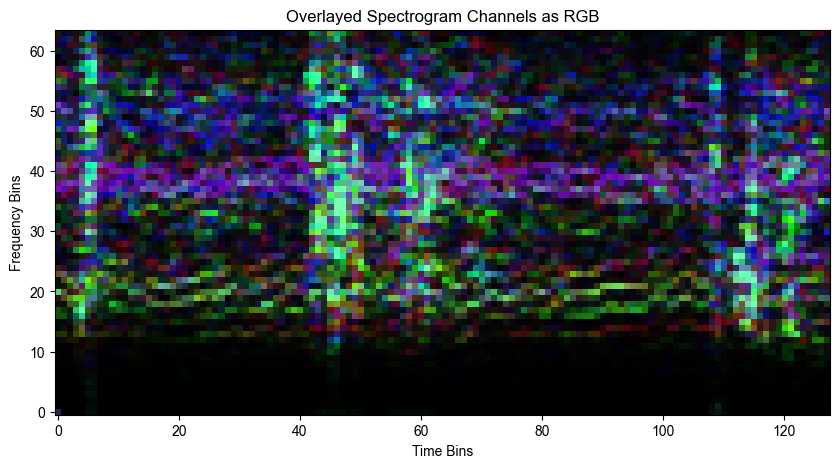

In [18]:
from examples.RGB_Spectrograms.plotting import overlay_channels_fixed


overlay_channels_fixed(s0w_reordered[0].swapaxes(0, 1))

(0.0, 256.0)

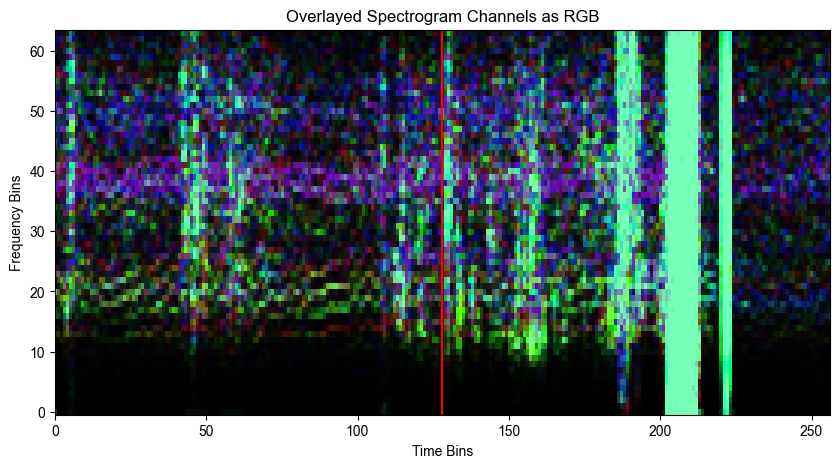

In [19]:
import matplotlib.pyplot as plt

overlay_channels_fixed(s0.swapaxes(0, 1))
plt.axvline(128, color='r')
plt.xlim(0, 256)

In [ ]:

from  encoder_block